# Load and Gen Scaling

Load and gen changes based on time of day, day of the week, and weather. You can see some government data [here](https://www.eia.gov/todayinenergy/detail.php?id=42915) for some fun data.

The load changes through the day provide another interesting problem to solve if you solve everything else. This requires a lot of work with a solver and manipulating the model.

## Scaling in our Hawaii40 model

We can use a sine wave to approximate load variations through the day if we are:
- min/max at 6pm/6am
- values in model are nominal - peaks are 10% below/above nominal.

Remember that as we increase the load, we also must increase then generation. The solver doesn't automatically change the generation values to meet the new load. If you don't increase the generation, this "missing power" will magically come from the slack bus or cause the solver to fail. 

In [2]:
def check_pf(info):
    converged = info.converged.any().any()
    max_error = info.error.max().max()
    print(f"Sim converged: {converged}")
    print(f"Max error: {max_error:.2e}")

    if ~converged:
        raise Exception("Sim didn't convert - results are garbage. Change to lpf()")

In [3]:
import pypsa
network = pypsa.Network()
network.import_from_csv_folder('data')
info = network.pf()
check_pf(info)

INFO:pypsa.network.io:Imported network 'Unnamed Network' has buses, generators, lines, loads, shunt_impedances, transformers
INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x000001BFD14C1A90> for snapshots Index(['now'], dtype='object', name='snapshot')


Sim converged: True
Max error: 1.21e-07


## Sanity check gen and load

The gen and load should be fairly close to each other, or something is really wrong with the model

In [4]:
pload_total = network.loads['p_set'].sum().round(0)
print(f"Total load in network {pload_total}")

Total load in network 1136.0


In [5]:
pgen_total = network.generators['p_set'].sum().round(0)
print(f"Total gen in network {pgen_total}")

Total gen in network 1155.0


## Sanity check gen and load solution

Our solved values for gen and load should closely match the set points.

In [6]:
network.generators_t['p'].sum(axis=1)

snapshot
now    1154.986963
dtype: float64

In [7]:
network.loads_t['p'].sum(axis=1)

snapshot
now    1136.29
dtype: float64

## Sine waves ftw

Let's create our load profile with the venerable sine wave.  

In [8]:
import matplotlib.pyplot as plt
import numpy as np

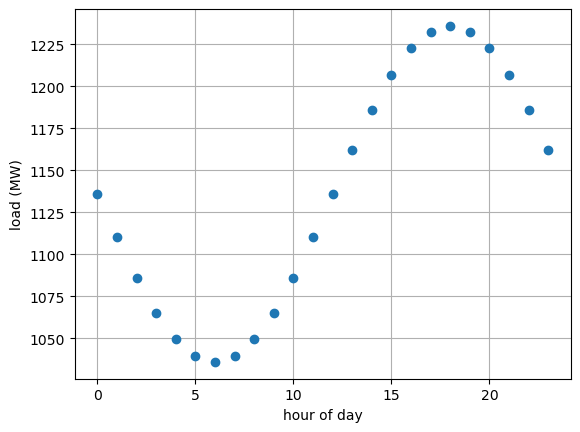

In [9]:
x = np.arange(24)
f = 1/24
offset = 1136
A = 100
C = 2*np.pi/2
y = A * np.sin(2*np.pi * f * x + C) + offset
plt.plot(x, y, 'o')
plt.xlabel('hour of day')
plt.ylabel('load (MW)')
plt.grid()
plt.show()

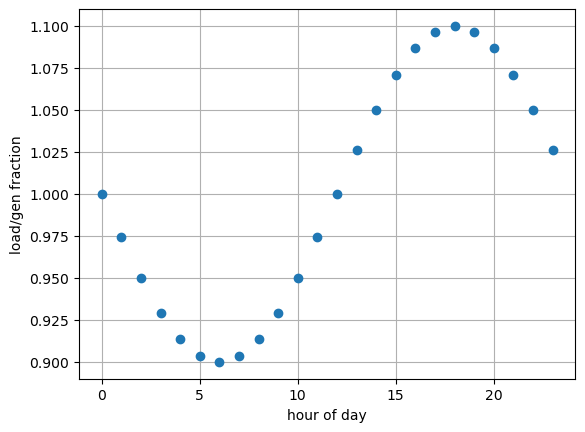

In [10]:
# I changed my mind - let's normalize the sine wave between 0-1 so I can just 
# scale each gen/load
x = np.arange(24)
f = 1/24
offset = 1
A = .1
C = 2*np.pi/2
y = A * np.sin(2*np.pi * f * x + C) + offset
plt.plot(x, y, 'o')
plt.xlabel('hour of day')
plt.ylabel('load/gen fraction')
plt.grid()
plt.show()

In [11]:
# To a list because some days I don't trust numpy
y.round(3).tolist()

[1.0,
 0.974,
 0.95,
 0.929,
 0.913,
 0.903,
 0.9,
 0.903,
 0.913,
 0.929,
 0.95,
 0.974,
 1.0,
 1.026,
 1.05,
 1.071,
 1.087,
 1.097,
 1.1,
 1.097,
 1.087,
 1.071,
 1.05,
 1.026]

## Let's scale those loads

Now that we have the weights calculated let's apply them to the model and solve the case again. Since we have time varying data we should try to figure out the pypsa snapshot.

In my experience, the snapshot pattern isn't typically built into simulators. I usually have to keep track of the data outside of the tool. 

In [12]:
hour = 6
scale = 1.1
print(f"Scaling load by {scale}")

Scaling load by 1.1


In [13]:
network.loads.head()

,bus,carrier,type,p_set,q_set,sign,active
name,,,,,,,
L0,2,,,60.70,0.0,-1.0,True
L1,3,,,59.39,0.0,-1.0,True
L2,4,,,22.47,0.0,-1.0,True
L3,6,,,27.46,0.0,-1.0,True
L4,7,,,37.01,0.0,-1.0,True


In [14]:
# Take a moment to appreciate how each this is
# We always scale P (real) and Q (imag) together because that's how it works
network.loads['p_set'] = scale * network.loads['p_set']
network.loads['q_set'] = scale * network.loads['q_set']

In [15]:
# Note that p_set is lower
network.loads.head()

,bus,carrier,type,p_set,q_set,sign,active
name,,,,,,,
L0,2,,,66.770,0.0,-1.0,True
L1,3,,,65.329,0.0,-1.0,True
L2,4,,,24.717,0.0,-1.0,True
L3,6,,,30.206,0.0,-1.0,True
L4,7,,,40.711,0.0,-1.0,True


In [16]:
# Rinse and repeat for gens
network.generators['p_set'] = scale * network.generators['p_set']
network.generators['q_set'] = scale * network.generators['q_set']

## Solve and compare

Solve the new case and see if the gens/loads are actually different (spoiler alert: they better be)

In [17]:
info = network.pf()
check_pf(info)

INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x000001BFD14C1A90> for snapshots Index(['now'], dtype='object', name='snapshot')


Sim converged: True
Max error: 2.77e-07


In [18]:
# should be about 1039 = 0.9 * 1155 
network.generators_t['p'].sum(axis=1)

snapshot
now    1272.605656
dtype: float64

In [19]:
# Should be about 1022 = 0.9 * 1136
network.loads_t['p'].sum(axis=1)

snapshot
now    1249.919
dtype: float64

In [20]:
network.lines_t['p0']

name,L0,L1,L2,L3,L4,L5,L6,L7,L8,L9,...,L67,L68,L69,L70,L71,L72,L73,L74,L75,L76
snapshot,,,,,,,,,,,,,,,,,,,,,
now,86.944261,86.944261,-24.725257,-73.312877,-73.312877,-67.687197,-67.687197,40.964316,50.326493,50.326493,...,59.015,40.208326,40.208326,36.711347,14.053298,35.602001,25.330309,-20.582982,-20.582982,27.456205
